# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots
using Statistics
using StatsBase

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]


1

## Simulate data

All SNPs have the same MAF

In [2]:
k = 0 # number of causal SNPs

qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 2022,
    y_distribution = Normal,
    τtrue = 0.01,
    T = Float64,
    maf = 0.3,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit null model

In [3]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
        derivative_test="first-order"
    )
);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.

* grad_f[          4] = -2.7531419550994855e+02    ~ -2.7586640170766782e+02  [ 2.002e-03]

Derivative checker detected 1 error(s).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variabl

In [4]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

@show qc_model.τ
@show qc_model.∇τ;

βtrue = [1.0, -0.5, 0.5]
qc_model.β = [0.9740664565977979, -0.5449071868918861, 0.4507960036263229]
qc_model.∇β = [6.348862047200754e-9, -3.6053718378836752e-9, 1.1929604554206108e-8]
θtrue = [0.1]
qc_model.θ = [0.11041961925588809]
qc_model.∇θ = [3.6974316275362185e-8]
qc_model.τ = [0.009884835862978891]
qc_model.∇τ = [-1.887361378294372e-7]


## Score test GWAS

In [5]:
# Bernoulli
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)
[pvals1 pvals2]

 39.274250 seconds (519.83 M allocations: 36.498 GiB, 6.64% gc time, 5.16% compilation time)
 15.925129 seconds (14.31 M allocations: 798.349 MiB, 0.78% gc time, 19.27% compilation time)


1000×2 Matrix{Float64}:
 0.0422337  0.0422337
 0.626052   0.626052
 0.41752    0.41752
 0.923725   0.923725
 0.899139   0.899139
 0.210571   0.210571
 0.876327   0.876327
 0.644442   0.644442
 0.212463   0.212463
 0.825381   0.825381
 0.201422   0.201422
 0.769411   0.769411
 0.896775   0.896775
 ⋮          
 0.161667   0.161667
 0.5821     0.5821
 0.167891   0.167891
 0.868515   0.868515
 0.881835   0.881835
 0.887746   0.887746
 0.423358   0.423358
 0.604095   0.604095
 0.092586   0.092586
 0.981627   0.981627
 0.172259   0.172259
 0.820025   0.820025

In [9]:
# Poisson
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)
[pvals1 pvals2]

 36.147133 seconds (511.42 M allocations: 36.067 GiB, 7.32% gc time, 1.02% compilation time)
 17.826907 seconds (13.52 M allocations: 737.805 MiB, 0.58% gc time, 14.21% compilation time)


1000×2 Matrix{Float64}:
 0.587118    0.587118
 0.639156    0.639156
 0.384689    0.384689
 0.738693    0.738693
 0.510028    0.510028
 0.00365622  0.00365622
 0.227462    0.227462
 0.734707    0.734707
 0.292638    0.292638
 0.411821    0.411821
 0.629741    0.629741
 0.848844    0.848844
 0.973128    0.973128
 ⋮           
 0.275256    0.275256
 0.517931    0.517931
 0.935623    0.935623
 0.580885    0.580885
 0.323186    0.323186
 0.398763    0.398763
 0.553326    0.553326
 0.368242    0.368242
 0.445115    0.445115
 0.0173726   0.0173726
 0.849858    0.849858
 0.431709    0.431709

In [15]:
# Normal
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G)
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)
[pvals1 pvals2]

 21.024380 seconds (225.62 M allocations: 15.342 GiB, 6.11% gc time, 1.73% compilation time)
 18.080967 seconds (23.46 M allocations: 3.287 GiB, 1.41% gc time, 14.78% compilation time)


1000×2 Matrix{Float64}:
 0.0826062  0.0832374
 0.770023   0.770071
 0.254867   0.25746
 0.680199   0.680199
 0.689235   0.690243
 0.525459   0.525584
 0.993506   0.993527
 0.282124   0.282272
 0.441822   0.442451
 0.557042   0.557037
 0.932353   0.932379
 0.690387   0.690401
 0.837113   0.837379
 ⋮          
 0.821519   0.822274
 0.562925   0.564201
 0.0340771  0.0353956
 0.551539   0.551538
 0.993941   0.993962
 0.899746   0.899749
 0.89777    0.897932
 0.264365   0.26438
 0.6128     0.612805
 0.661763   0.6624
 0.168152   0.168135
 0.509202   0.509352

## Gaussian longitudinal correctness

Once we take into account the effect of $\tau$, the p-values will still be slightly different compared to longitudinal GWAS. Here we show the reason is due to numerical issues when inverting $P$ in the beginning.

In [13]:
@time pvals1 = QuasiCopula.GWASCopulaVCModel(qc_model, G)

P = [113.05911545593877 -0.11163593560864356 -0.3196625214495707 21.479304233311986 -93.8906336998371; -0.11163593560864364 139.07103912186128 -0.3025554054692216 8.720278525194463 -80.78602874576163; -0.3196625214495707 -0.3025554054692215 138.56909390714924 -15.774601971211679 35.455454214897536; 21.479304233311986 8.720278525194463 -15.774601971211679 69151.18443977748 -34427.74339925807; -93.8906336998371 -80.78602874576163 35.455454214897536 -34427.74339925807 7.903222759764801e7]
Pinv = [0.008845522559639796 7.321446164254837e-6 2.0107344783713935e-5 -2.7392398388129613e-6 9.313724921388113e-9; 7.321446164254842e-6 0.007190670145673407 1.561272175515519e-5 -9.020241599270357e-7 6.958995141201502e-9; 2.0107344783713938e-5 1.5612721755155183e-5 0.007216883879251512 1.636846685927368e-6 -2.484755688976294e-9; -2.739239838812961e-6 -9.020241599270357e-7 1.636846685927368e-6 1.4465541067466773e-5 6.296517965795261e-9; 9.313724921388114e-9 6.958995141201502e-9 -2.4847556889762937e-9 6.

LoadError: UndefVarError: fdsa not defined

In [14]:
@time pvals2 = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

P = [113.05911545593902 -0.11163593560864114 -0.31966252144957114 21.479304233312003 -93.89063369983887; -0.11163593560864153 139.07103912186108 -0.3025554054692221 8.720278525194463 -80.78602874577089; -0.3196625214495708 -0.3025554054692223 138.5690939071499 -15.774601971211682 35.455454214897166; 21.479304233311996 8.720278525194457 -15.774601971211686 8643.898054971809 -434108.4588004997; -93.89063369983882 -80.78602874577143 35.45545421489705 -434108.4588004997 7.903222759764946e7]
Pinv = [0.008850486661227997 8.910050122734006e-6 1.7104561173109193e-5 -2.9610568443941362e-5 -1.5212916854451934e-7; 8.910050122734032e-6 0.007191178487771645 1.465174367594188e-5 -9.501920739791808e-6 -4.4837409214650266e-8; 1.7104561173109176e-5 1.4651743675941894e-5 0.007218700236852495 1.789084932088198e-5 9.506775365241243e-8; -2.961056844394135e-5 -9.501920739791794e-6 1.789084932088199e-5 0.000159915326968614 8.783304752164311e-7; -1.5212916854451923e-7 -4.4837409214650154e-8 9.506775365241253e

LoadError: UndefVarError: fdsa not defined

In [11]:
# Bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

 39.084778 seconds (510.64 M allocations: 36.026 GiB, 9.62% gc time, 0.01% compilation time)


1000-element Vector{Float64}:
 0.04237106978625808
 0.6260408273210571
 0.4175210805098005
 0.9237273618122198
 0.899139076785499
 0.2105685791891232
 0.87632805457857
 0.6444703491799723
 0.212467061196613
 0.8254159007580693
 0.20175431671757915
 0.7693680902423318
 0.896771272041161
 ⋮
 0.1622760248460603
 0.582132875902791
 0.16797237561465403
 0.8685136689983323
 0.8818350841267775
 0.8878162759603672
 0.4233661125771992
 0.6039925981896165
 0.09266969057460371
 0.9816271441316824
 0.1723419962895368
 0.8199887920039918

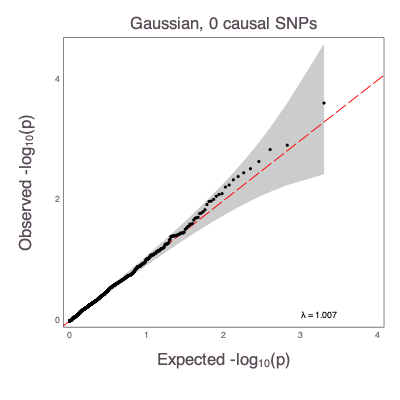

In [12]:
# gaussian
qq(pvals, dpi=80, titles="Gaussian, $k causal SNPs")
display("image/png", read("qqplot.png"))

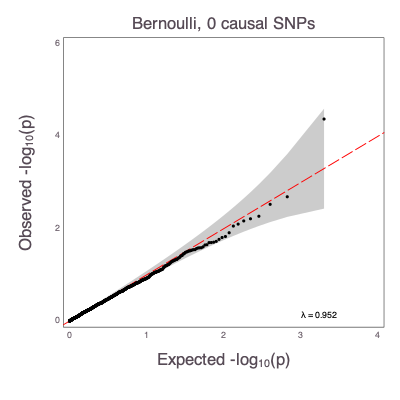

In [12]:
# Bernoulli
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [7]:
# autodiff Bernoulli
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

 16.146223 seconds (14.23 M allocations: 794.285 MiB, 0.76% gc time, 18.86% compilation time)


1000-element Vector{Float64}:
 0.04223373038042875
 0.6260522783632376
 0.4175203872666951
 0.9237248799378779
 0.8991389365186702
 0.21057058844454005
 0.8763265947972056
 0.6444418776606714
 0.21246306979667423
 0.8253806794098849
 0.20142208400694242
 0.7694111559521428
 0.8967750752462262
 ⋮
 0.16166717166138747
 0.5820995811997104
 0.16789123818202153
 0.8685145268128949
 0.8818345013347856
 0.887746210550894
 0.42335825251362047
 0.6040949737838895
 0.09258604112184637
 0.9816270415583391
 0.17225901871224816
 0.8200253670141937

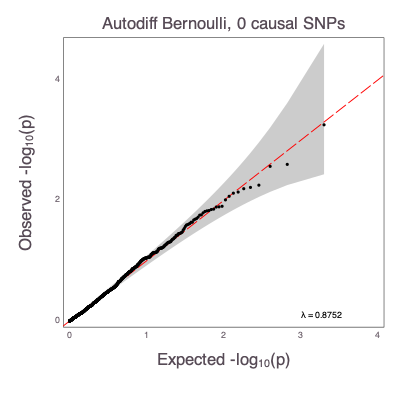

In [24]:
qq(pvals, dpi=80, titles="Autodiff Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))